##**1.Load the dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [ ]:
# Load the dataset
file_path = '/content/airline-passenger-traffic(1).csv'
data = pd.read_csv(file_path,header=None)
data.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
# Assign proper column names
data.columns = ['Date', 'Passengers']

# Display the DataFrame with new headers
print(data.head())

      Date  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05       121.0


In [ ]:
# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Passengers
Date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


##**2.Visualize the data**

In [ ]:
data.isnull().sum()

,0
Passengers,4


In [ ]:
data.shape

(144, 1)

In [ ]:
#impute missing values
data.fillna(method='ffill', inplace=True)

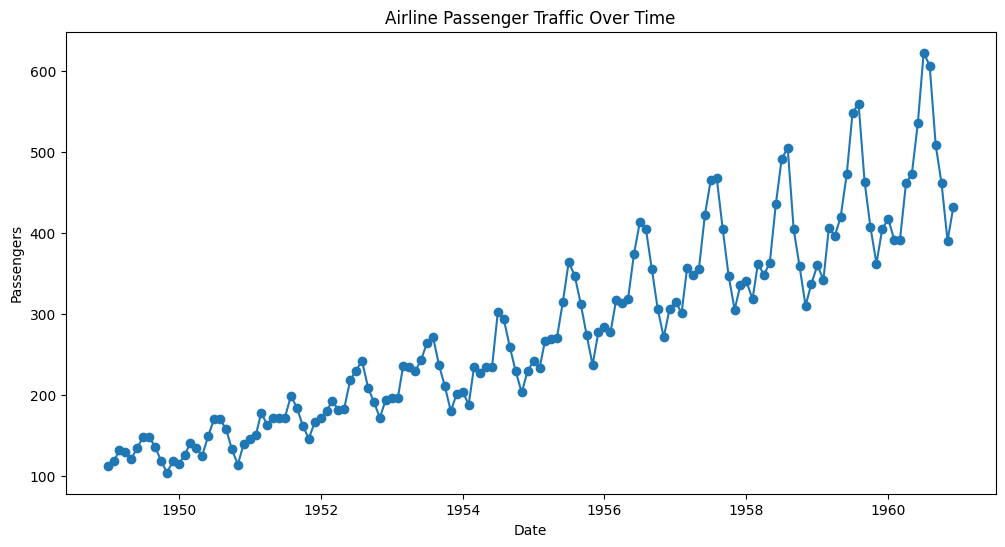

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'], marker='o', linestyle='-')
plt.title('Airline Passenger Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.show()

##**3.Check for Stationarity**

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Passengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: 1.0041580400746162
p-value: 0.9943096275340996
The time series is non-stationary.


In [ ]:
#apply differencing to make the series stationary
data['Passengers_diff'] = data['Passengers'].diff().dropna()

result_diff = adfuller(data['Passengers_diff'].dropna())
print("Differenced ADF Statistic:", result_diff[0])
print("Differenced p-value:", result_diff[1])

if result_diff[1] < 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is non-stationary.")

Differenced ADF Statistic: -3.3106920971395697
Differenced p-value: 0.014407250132429612
The differenced time series is stationary.


In [ ]:
data.isnull().sum()

,0
Passengers,0
Passengers_diff,1


In [ ]:
data['Passengers_diff'] = data['Passengers'].diff().dropna()

##**4.Auto SARIMA: Determine Parameters**

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Run auto_arima to determine SARIMA parameters
auto_sarima_model = auto_arima(data['Passengers'],
                               seasonal=True, m=12,  # m is the seasonal period
                               trace=True,
                               suppress_warnings=True,
                               stepwise=True)

# Display the optimal parameters
print("Optimal SARIMA order:", auto_sarima_model.order)
print("Optimal Seasonal order:", auto_sarima_model.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1075.742, Time=1.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1094.855, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1077.405, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1075.153, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1075.970, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1075.392, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1074.392, Time=0.77 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1070.622, Time=2.24 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.33 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1096.852, Time=1.35 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1077.845, Time=2.12 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=1072.456, Time=2.35 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1080.275, Time=2.23 sec
 ARIMA(1,1,2)(1,1,2)[12]     

##**5. Split Data into Training and Testing Sets**

In [ ]:
train = data['Passengers'][:-7]
test = data['Passengers'][-7:]

##**6. Build and Train the SARIMA Model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
sarima_model = SARIMAX(train,
                       order=auto_sarima_model.order,
                       seasonal_order=auto_sarima_model.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Print model summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  137
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -401.043
Date:                            Sat, 25 Jan 2025   AIC                            816.086
Time:                                    18:44:37   BIC                            834.109
Sample:                                01-01-1949   HQIC                           823.373
                                     - 05-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5885      2.974     -0.198      0.843      -6.418       5.241
ma.L1          0.0749      2.986   

##**7. Make Predictions**

In [ ]:
# Make predictions on the test set
predictions = sarima_result.predict(start=len(train),
                                    end=len(train) + len(test) - 1,
                                    dynamic=False)
print(predictions)

1960-06-01    524.929444
1960-07-01    597.887322
1960-08-01    613.330367
1960-09-01    509.323432
1960-10-01    455.877656
1960-11-01    408.587312
1960-12-01    448.037882
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
data.isnull().sum()

,0
Passengers,0
Passengers_diff,1


In [ ]:
data['Passengers_diff'] = data['Passengers'].diff()
data = data.dropna(subset=['Passengers_diff'])
data.isnull().sum()

,0
Passengers,0
Passengers_diff,0


In [ ]:
# Revert differencing
data['Passengers'] = data['Passengers'] + data['Passengers_diff'].cumsum()

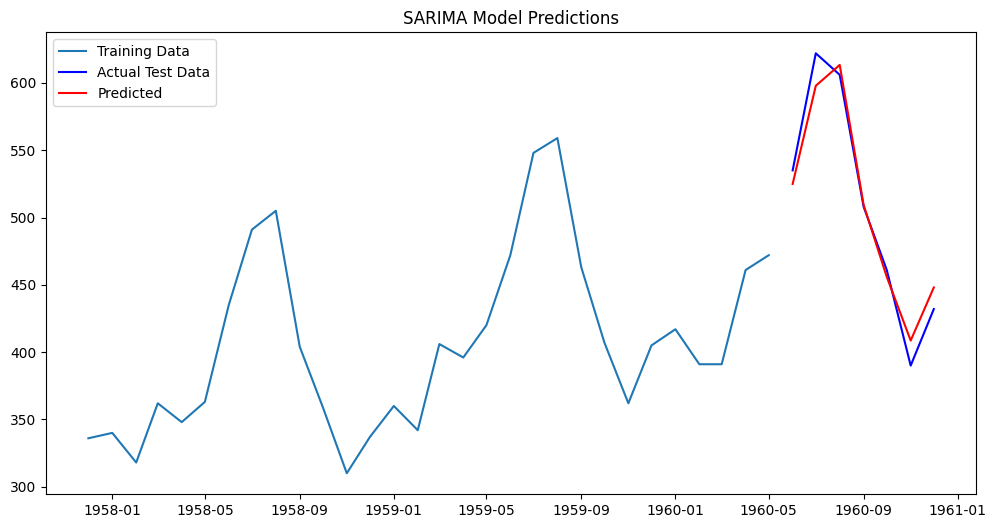

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label="Training Data")
plt.plot(test, label="Actual Test Data", color='blue')
plt.plot(test.index, predictions, label="Predicted", color='red')
plt.title("SARIMA Model Predictions")
plt.legend()
plt.show()

##**8. Evaluate the Model**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 11.797795925917049
Mean Squared Error (MSE): 195.32333561126597
Root Mean Squared Error (RMSE): 13.975812520610956


##**9. Forecast Future Values**

In [ ]:
#predict future valuesfor next 30 days
future_forecast=sarima_result.predict(start=len(data), end=len(data)+30, dynamic=False)
future_forecast.head()

,predicted_mean
1960-12-01,448.037882
1961-01-01,463.645846
1961-02-01,438.381973
1961-03-01,449.936098
1961-04-01,507.704116


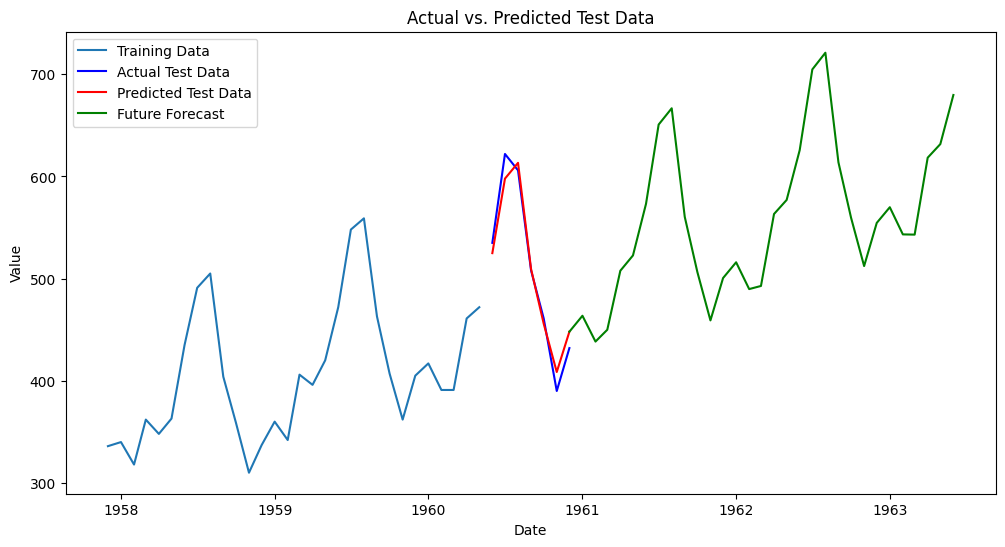

In [ ]:
#plot future forecast with actual data
plt.figure(figsize=(12, 6))
plt.plot(train[-30:], label="Training Data")
plt.plot(test, label="Actual Test Data", color='blue')
plt.plot(test.index, predictions, label="Predicted Test Data", color='red')
plt.plot(future_forecast, label="Future Forecast", color='green')

plt.title("Actual vs. Predicted Test Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()